In [1]:
# Imports & plotting style

import numpy as np

import matplotlib as mpl
mpl.rc('font', family='serif')
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic

from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
import os

# optional Sgr rotation helper (if file is available alongside notebook)
try:
    import sphere_rotate as sr  # e.g., sphere_rotate.py
except Exception:
    sr = None  # Sgr plots will be skipped if not present

# plotting style
plt.rcParams.update({
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

np.set_printoptions(suppress=True)

In [2]:
# Draw survey box 

def draw_survey_box(x, y, ax=None, *, label="Survey region", **kwargs):

    if ax is None:
        ax = plt.gca()

    xmin, xmax = x
    ymin, ymax = y

    xs = [xmin, xmax, xmax, xmin, xmin]
    ys = [ymin, ymin, ymax, ymax, ymin]

    (line,) = ax.plot(xs, ys, linewidth=2,
                      solid_capstyle="round", label=label, **kwargs)
    return line

In [26]:
# Load catalogs (reuses if already present)

expanded_rg = False  # if True, loads the expanded RG catalog

# Load RG catalog
if expanded_rg:
        # with fits.open('https://people.ast.cam.ac.uk/~vasily/data/rg_gaia2mass_expanded.fits', memmap=True) as hdul:
    with fits.open(os.path.expanduser('~/data/gaia/rg_gaia2mass_expanded.fits'), memmap=True) as hdul:
        dg = hdul[1].data
else:
    with fits.open('https://people.ast.cam.ac.uk/~vasily/data/rg_gaia2mass.fits', memmap=True) as hdul:
        dg = hdul[1].data

# Load BHB catalog
with fits.open('https://people.ast.cam.ac.uk/~vasily/data/BHB_EDR3_2023_with_mags.fits', memmap=True) as hdul:
    bhb = hdul[1].data

# Load XP catalog
with fits.open('https://people.ast.cam.ac.uk/~vasily/data/catalogues/gaia_xp_andrae_parallax01.fits', memmap=True) as hdul:
    da = hdul[1].data

# Load RRab catalog
with fits.open('../gaiadr3_rrab_data.fits', memmap=True) as hdul:
    rrab = hdul[1].data

In [27]:
# Configuration knobs

# Survey box (in RA[-180,+180], Dec deg)
tarx = [-45.0,  15.0]
tary = [-20.0,   0.0]

# Requested pointings
n_pointings = 35  # WEAVE 2° diameter fields

# RGB selection parameters (Gaia RG catalog)
rgb_params = {
    'clean':   {'rpm_cut': 18.0, 'par_cut': 0.2, 'col_cut': 1., 'mag_lim': 18.0, 'dist_cut': 50.0, 'priority': 10},
    'relaxed': {'rpm_cut': 18.5, 'par_cut': 0.25, 'col_cut': 1.0, 'mag_lim': 18.5, 'dist_cut': 30.0, 'priority':  9},
}

# BHB selection parameters (PS1 g cut as distance proxy)
bhb_params = {'mag_cut': 18.0, 'priority': 8}

# XP selection parameters (Andrae Gaia-XP giants)
xp_params = {
    'ebv_max': 0.1,
    'logg_max': 2.0,
    'teff_max': 5000.0,
    'mh_max': -1.5,
    'gmag_max': 17.0,
    'rpm_max': 17.0,
    'use_dist': False,     # set True to also require r_med_photogeo > 10 kpc
    'dist_pc_min': 1.0e4,  # 10 kpc in parsec
    'priority': 7
}

In [28]:
# RA wrap helpers, XP extinction-corrected mags/colors, and RPM

def to_ra180(ra_deg):
    """Convert RA from [0,360] to [-180,180] efficiently."""
    return ((ra_deg + 180.0) % 360.0) - 180.0

# RA wrapped for region masks
ra180     = to_ra180(dg['ra'])
bhbra180  = to_ra180(bhb['ra'])
dara180   = to_ra180(da['ra'])

# --- XP extinction & RPM ---
# Extinction coefficients (same prescription you used)
A0  = 3.1*da['ebv']
kg  = 0.9761 - 0.1704*da['bp_rp']
kbp = 1.1517 - 0.0871*da['bp_rp']
krp = 0.6104 - 0.0170*da['bp_rp']

ag  = kg*A0
abp = kbp*A0
arp = krp*A0

# extinction-corrected XP photometry
mg_xp  = da['PHOT_G_MEAN_MAG'] - ag                             # G_0
col_xp = da['bp_rp'] - abp + arp                                # (BP-RP)_0

# Galactic latitude (for RPM)
c_xp  = SkyCoord(ra=da['ra']*u.deg, dec=da['dec']*u.deg).transform_to(Galactic())
b_deg = np.array(c_xp.b / u.deg)

# reduced proper motion for XP
pm_xp   = np.hypot(da['pmra'], da['pmdec'])                     # mas/yr
darpm   = mg_xp + 5.0*np.log10(np.clip(pm_xp, 1e-9, None)) - 1.47*np.sin(np.deg2rad(np.abs(b_deg)))

N_RRab (40.0–100.0 kpc) = 36,879


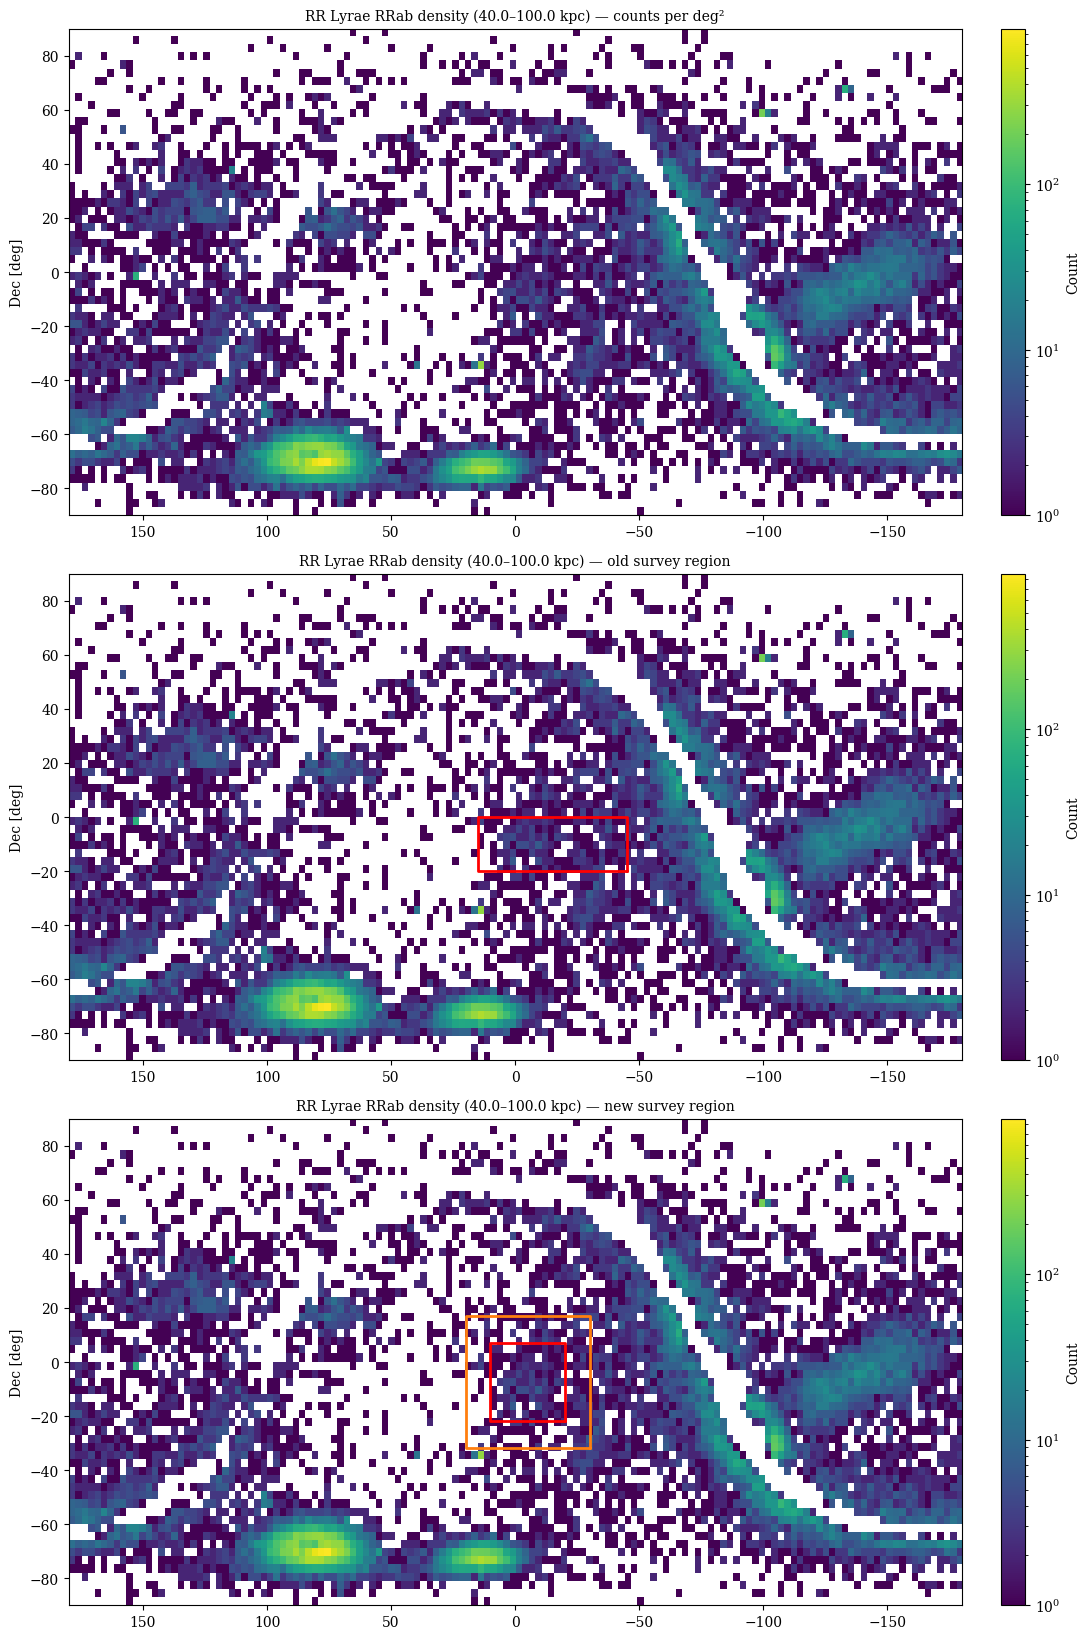

In [29]:
# RRab plot

# Distance cut
dist_mm = (40.0, 100.0)  # kpc

# Wrap RA to [-180,180]
ra180_rrab     = to_ra180(rrab['ra'])

# --- Select RRab between 40 and 80 kpc ---
mask_dist = (rrab['distance_kpc'] > dist_mm[0]) & (rrab['distance_kpc'] < dist_mm[1])

sel = mask_dist

# --- 2D histogram in 1° bins (counts per deg²) ---
ra_edges = np.linspace(-180.0, 180.0, 141)  # RA centered on 0°
dec_edges = np.linspace(-90.0, 90.0, 61)

H, ra_e, dec_e = np.histogram2d(ra180_rrab[sel], rrab['dec'][sel], bins=[ra_edges, dec_edges])

# Plot the same RRab density map three times, stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(11, 16.5))

ax = axs[0]
im = ax.imshow(
    H.T,
    extent=[ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]],
    origin='lower',
    aspect='auto',
    norm=LogNorm(vmin=1, vmax=max(1, H.max()))
)
ax.set_xlim(180, -180)
ax.set_ylabel("Dec [deg]")
ax.set_title(f"RR Lyrae RRab density ({dist_mm[0]}–{dist_mm[1]} kpc) — counts per deg²")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")

# -----------------------------

ax = axs[1]
im = ax.imshow(
    H.T,
    extent=[ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]],
    origin='lower',
    aspect='auto',
    norm=LogNorm(vmin=1, vmax=max(1, H.max()))
)

draw_survey_box(tarx, tary, ax=ax, color="red")
ax.set_xlim(180, -180)
ax.set_ylabel("Dec [deg]")
ax.set_title(f"RR Lyrae RRab density ({dist_mm[0]}–{dist_mm[1]} kpc) — old survey region")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")

# -----------------------------

ax = axs[2]
im = ax.imshow(
    H.T,
    extent=[ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]],
    origin='lower',
    aspect='auto',
    norm=LogNorm(vmin=1, vmax=max(1, H.max()))
)

tarx_new = np.asarray([-20.0,  10.0], float)
tary_new = np.asarray([-22.0,   7.0], float)
draw_survey_box(tarx_new, tary_new, ax=ax, color='red', label="New survey region")

off_deg = 10
tarx_comp = tarx_new + np.array([-off_deg, off_deg])
tary_comp = tary_new + np.array([-off_deg, off_deg])
draw_survey_box(tarx_comp, tary_comp, ax=ax, color='tab:orange', label="New survey region")


ax.set_xlim(180, -180)
ax.set_ylabel("Dec [deg]")
ax.set_title(f"RR Lyrae RRab density ({dist_mm[0]}–{dist_mm[1]} kpc) — new survey region")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")

print(f"N_RRab ({dist_mm[0]}–{dist_mm[1]} kpc) = {np.count_nonzero(sel):,}")
plt.tight_layout()
plt.show()

Area_new = 862.56 deg², Area_comp−new = 1566.48 deg², scale = 0.551
N(new) = 6,604, N(comp−new) = 14,075


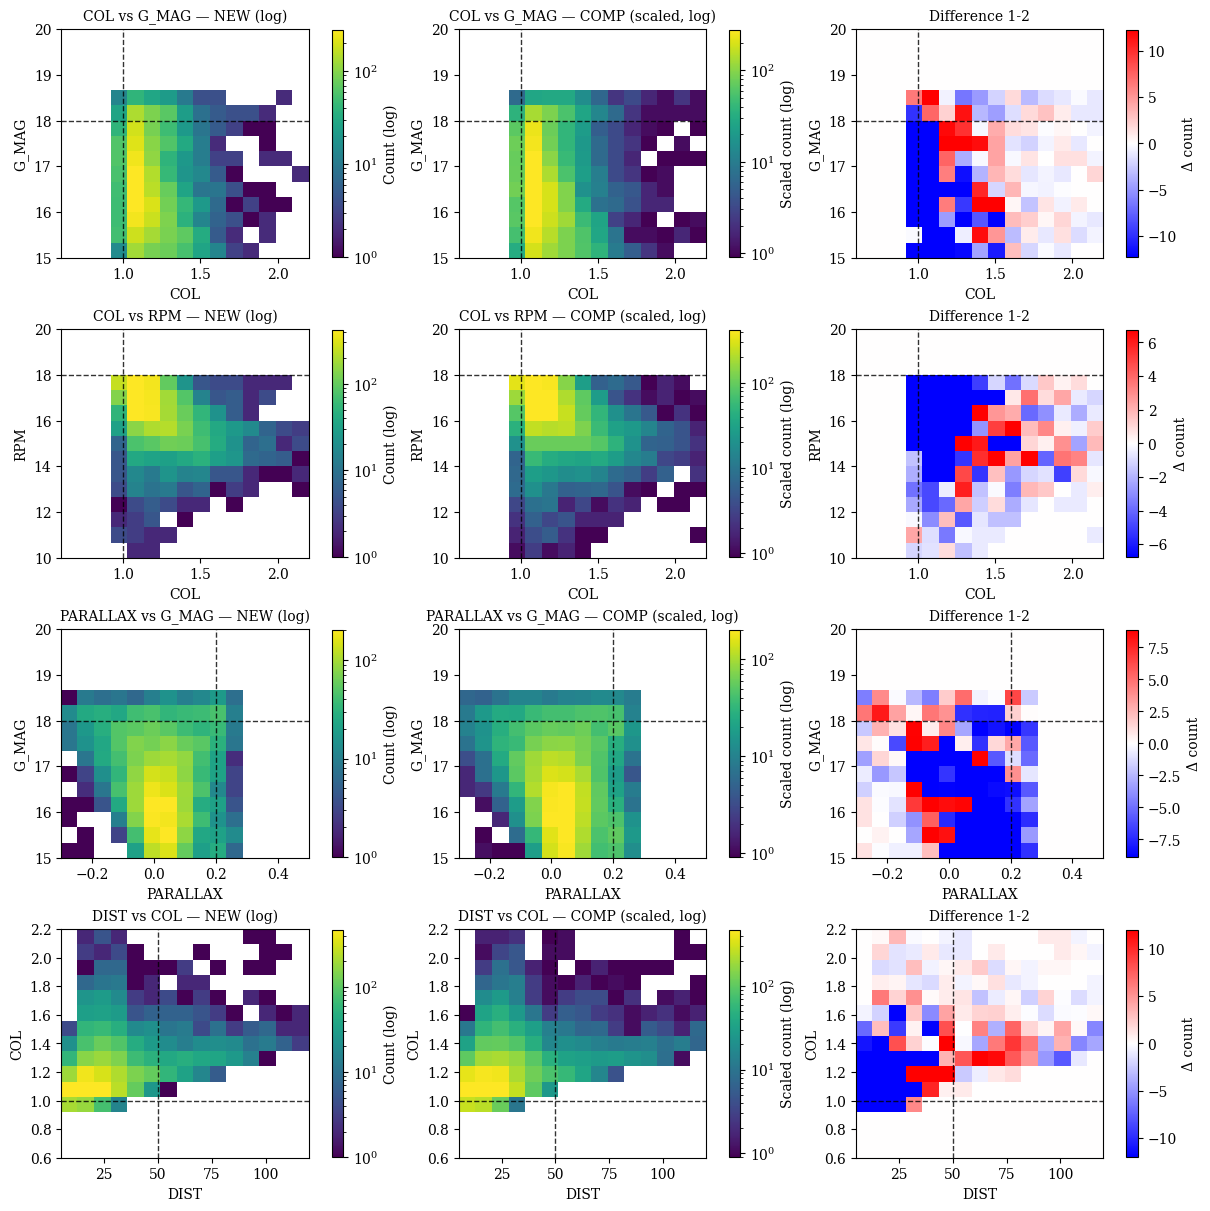

In [30]:
# RG SELECTION OPTIMIZER

# Percentile for diff color scale
perc = 98

# Per-axis ranges (must match the labels you plot: xlab/ylab)
rgb_axis_ranges = {
    'COL': (0.6, 2.2),
    'G_MAG': (15.0, 20),
    'RPM': (10.0, 20.0),
    'PARALLAX': (-0.3, 0.5),
    'DIST': (5.0, 120.0),
}

# Per-axis bin counts
rgb_axis_bins = {
    'COL': 15,
    'G_MAG': 15,
    'RPM': 15,
    'PARALLAX': 15,
    'DIST': 15,
}

# Column names in your dg are UPPERCASE (per notebook)
COL   = np.asarray(dg['COL'], float)               if 'COL'               in dg.dtype.names else None
Gmag  = np.asarray(dg['MG'], float)   if 'MG'   in dg.dtype.names else None
RPM   = np.asarray(dg['RPM'], float)               if 'RPM'               in dg.dtype.names else None
PAR   = np.asarray(dg['PARALLAX'], float)          if 'PARALLAX'          in dg.dtype.names else None
DIST  = np.asarray(dg['DIST'], float)              if 'DIST'              in dg.dtype.names else None
dec   = np.asarray(dg['DEC'] if 'DEC' in dg.dtype.names else dg['dec'], float)

# ===== 1) Simple rectangular sky selections in ra180 / dec =====
# tarx_* and tary_* are two-element arrays: [lo, hi]
ra_new_lo,  ra_new_hi  = np.sort(np.asarray(tarx_new,  float))
dec_new_lo, dec_new_hi = np.sort(np.asarray(tary_new,  float))

ra_c_lo,    ra_c_hi    = np.sort(np.asarray(tarx_comp, float))
dec_c_lo,   dec_c_hi   = np.sort(np.asarray(tary_comp, float))

m_new = (
    (ra180 >= ra_new_lo) & (ra180 <= ra_new_hi) &
    (dec   >= dec_new_lo) & (dec   <= dec_new_hi)
)
m_comp_box = (
    (ra180 >= ra_c_lo) & (ra180 <= ra_c_hi) &
    (dec   >= dec_c_lo) & (dec   <= dec_c_hi)
)
# comparison with the middle (survey box) removed
m_comp = m_comp_box & (~m_new)

# ===== 2) Area ratio for scaling comparison (deg^2; cos(mid-dec)) =====
def _rect_area_deg2(ra_lo, ra_hi, dec_lo, dec_hi):
    d_ra  = float(ra_hi) - float(ra_lo)
    d_dec = float(dec_hi) - float(dec_lo)
    dec_mid = 0.5 * (float(dec_lo) + float(dec_hi))
    return abs(d_ra) * abs(d_dec) * np.cos(np.deg2rad(dec_mid))

area_new       = _rect_area_deg2(ra_new_lo, ra_new_hi, dec_new_lo, dec_new_hi)
area_comp_full = _rect_area_deg2(ra_c_lo,   ra_c_hi,   dec_c_lo,   dec_c_hi)
area_comp_excl = max(area_comp_full - area_new, 1e-12)  # comp minus middle
scale = area_new / area_comp_excl

print(f"Area_new = {area_new:.2f} deg², Area_comp−new = {area_comp_excl:.2f} deg², scale = {scale:.3f}")
print(f"N(new) = {int(m_new.sum()):,}, N(comp−new) = {int(m_comp.sum()):,}")

# ===== 3) Define RGB-relevant spaces from your knobs =====
# Choose which rgb_params setting to annotate: 'clean' (default) or 'relaxed'
rgb_set = 'clean' if 'clean' in rgb_params else next(iter(rgb_params.keys()))
knobs = rgb_params[rgb_set]

# Map axis names to columns and to knob names for threshold overlays
spaces = [
    # (X array, Y array, X label, Y label, X threshold key, Y threshold key)
    (COL,  Gmag,  'COL',  'G_MAG', 'col_cut', 'mag_lim'),
    (COL,  RPM,   'COL',  'RPM',             'col_cut', 'rpm_cut'),
    (PAR,  Gmag,  'PARALLAX', 'G_MAG', 'par_cut', 'mag_lim'),
    (DIST, COL,   'DIST', 'COL',             'dist_cut', 'col_cut'),
]

# Filter out spaces where required columns are missing
spaces = [s for s in spaces if (s[0] is not None and s[1] is not None)]

# ===== 4) 2D densities: NEW, scaled COMP, DIFF per row, with threshold overlays =====

nrows = len(spaces)
fig, axes = plt.subplots(nrows, 3, figsize=(12, 3*nrows), constrained_layout=True)
if nrows == 1:
    axes = np.array([axes])  # ensure 2D indexing

for i, (X, Y, xlab, ylab, xkey, ykey) in enumerate(spaces):
    x_new = X[m_new];  y_new = Y[m_new]
    x_cmp = X[m_comp]; y_cmp = Y[m_comp]

    mfn = np.isfinite(x_new) & np.isfinite(y_new)
    mfc = np.isfinite(x_cmp) & np.isfinite(y_cmp)

    x_all = np.concatenate([x_new[mfn], x_cmp[mfc]])
    y_all = np.concatenate([y_new[mfn], y_cmp[mfc]])
    if x_all.size == 0 or y_all.size == 0:
        # Skip empty space
        for j in range(3):
            axes[i, j].axis('off')
        continue

    xr = rgb_axis_ranges[xlab]
    yr = rgb_axis_ranges[ylab]
    if xr[1] == xr[0]: xr = (xr[0]-0.5, xr[1]+0.5)
    if yr[1] == yr[0]: yr = (yr[0]-0.5, yr[1]+0.5)

    bx = rgb_axis_bins[xlab]  
    by = rgb_axis_bins[ylab]  

    H_new, xedges, yedges = np.histogram2d(x_new[mfn], y_new[mfn],
                                       bins=[bx, by], range=[xr, yr])
    H_cmp, _, _           = np.histogram2d(x_cmp[mfc], y_cmp[mfc],
                                       bins=[xedges, yedges])
    H_cmp_scaled = H_cmp * scale
    H_diff = H_new - H_cmp_scaled
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Column (i): NEW
    ax = axes[i, 0]
    Hn = H_new.copy().astype(float)
    Hn[Hn <= 0] = np.nan  # log needs > 0
    vmax_new = np.nanpercentile(Hn, perc)  # perc = 98 above
    vmin_new = max(1e-6, np.nanmin(Hn)) if np.isfinite(np.nanmin(Hn)) else 1e-6
    if not np.isfinite(vmax_new) or vmax_new <= vmin_new:
        vmax_new = max(vmin_new*10, 1.0)
    im0 = ax.imshow(Hn.T, extent=extent, origin='lower', aspect='auto',
                    norm=LogNorm(vmin=vmin_new, vmax=vmax_new))
    ax.set_title(f"{xlab} vs {ylab} — NEW (log)")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04, label="Count (log)")

    # Column (ii): COMP (scaled)
    ax = axes[i, 1]
    Hcs = H_cmp_scaled.copy().astype(float)
    Hcs[Hcs <= 0] = np.nan  # log needs > 0
    vmax_cmp = vmin_new
    vmin_cmp = vmax_new

    im1 = ax.imshow(Hcs.T, extent=extent, origin='lower', aspect='auto',
                    norm=LogNorm(vmin=vmin_cmp, vmax=vmax_cmp))
    ax.set_title(f"{xlab} vs {ylab} — COMP (scaled, log)")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label="Scaled count (log)")

    # Column (iii): DIFF = NEW − COMP (scaled)
    ax = axes[i, 2]
    vmax = np.nanpercentile(H_diff, perc)
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0

    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
    im2 = ax.imshow(
        H_diff.T,
        extent=extent, origin='lower', aspect='auto',
        norm=norm, cmap='bwr'   # bwr has white exactly at the center
    )

    ax.set_title(f"Difference 1-2")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label="Δ count")

    # ---- threshold overlays from rgb_params[rgb_set] ----
    # Vertical line if xkey present; horizontal line if ykey present
    ax0, ax1, ax2 = axes[i, 0], axes[i, 1], axes[i, 2]
    if xkey in knobs and np.isfinite(knobs[xkey]):
        for axk in (ax0, ax1, ax2):
            axk.axvline(knobs[xkey], ls='--', lw=1, alpha=0.8, color='black')
    if ykey in knobs and np.isfinite(knobs[ykey]):
        for axk in (ax0, ax1, ax2):
            axk.axhline(knobs[ykey], ls='--', lw=1, alpha=0.8, color='black')


plt.savefig(f'../plots/rg_selection_optimizer{"_expanded" if expanded_rg else ""}.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# Apply selections via boolean masks

# RGB selection parameters (Gaia RG catalog)
rgb_params = {
    'clean':   {'rpm_cut': 19.0, 'par_cut': 0.2, 'col_cut': 1., 'mag_lim': 19.5, 'dist_cut': 25.0, 'priority': 10},
    'relaxed': {'rpm_cut': 20, 'par_cut': 0.25, 'col_cut': 0.9, 'mag_lim': 20, 'dist_cut': 20.0, 'priority':  9},
}

# Target coordinates
tarx = tarx_new
tary = tary_new

# -----------------------------------------------------------------------------------------------------

# survey box masks
mask_box_rgb = (ra180 > tarx[0]) & (ra180 < tarx[1]) & (dg['dec']  > tary[0]) & (dg['dec']  < tary[1])
mask_box_bhb = (bhbra180 > tarx[0]) & (bhbra180 < tarx[1]) & (bhb['dec'] > tary[0]) & (bhb['dec'] < tary[1])
mask_box_xp  = (dara180  > tarx[0]) & (dara180  < tarx[1]) & (da['dec']  > tary[0]) & (da['dec']  < tary[1])

# RGB masks
def rgb_mask(kind='clean'):
    p = rgb_params[kind]
    return (
        (dg['parallax'] < p['par_cut']) &
        (dg['col']      > p['col_cut']) &
        (dg['mg']       < p['mag_lim']) &
        (dg['dist']     > p['dist_cut']) &
        (dg['rpm']      < p['rpm_cut'])
    )

mask_rgb_clean_global   = rgb_mask('clean')
mask_rgb_relaxed_global = rgb_mask('relaxed')

mask_rgb_clean_field    = mask_rgb_clean_global   & mask_box_rgb
mask_rgb_relaxed_field  = mask_rgb_relaxed_global & mask_box_rgb

# "additional relaxed" (relaxed but not clean)
mask_relaxed_add_global = mask_rgb_relaxed_global & ~mask_rgb_clean_global
mask_relaxed_add_field  = mask_relaxed_add_global & mask_box_rgb

# BHB masks
mask_bhb_global = (bhb['ps1g'] > bhb_params['mag_cut'])
mask_bhb_field  = mask_bhb_global & mask_box_bhb

# XP masks (Andrae)
mask_xp_base = (
    (da['ebv']  < xp_params['ebv_max']) &
    (da['logg'] < xp_params['logg_max']) &
    (da['TEFF'] < xp_params['teff_max']) &
    (da['mh']   < xp_params['mh_max']) &
    (da['PHOT_G_MEAN_MAG'] < xp_params['gmag_max']) &
    (darpm < xp_params['rpm_max'])
)
if xp_params['use_dist'] and ('r_med_photogeo' in da.dtype.names):
    mask_xp_base &= (da['r_med_photogeo'] > xp_params['dist_pc_min'])

mask_xp_global = mask_xp_base
mask_xp_field  = mask_xp_base & mask_box_xp

# materialize indices once (plain ndarrays)
wtar1        = np.nonzero(mask_rgb_clean_global)[0]
wtar12       = np.nonzero(mask_rgb_relaxed_global)[0]
wtar2        = np.nonzero(mask_bhb_global)[0]
wtar3        = np.nonzero(mask_xp_global)[0]

wtar1_xy     = np.nonzero(mask_rgb_clean_field)[0]
wtar12_xy    = np.nonzero(mask_rgb_relaxed_field)[0]
wtar2_xy     = np.nonzero(mask_bhb_field)[0]
wtar3_xy     = np.nonzero(mask_xp_field)[0]

keep_wtar12_xy     = np.nonzero(mask_relaxed_add_field)[0]    # additional relaxed (field)
relaxed_global_add = np.nonzero(mask_relaxed_add_global)[0]   # additional relaxed (global)

In [32]:
# Summary table (spherical areas + expected per pointing)

def spherical_box_area_deg2(ra_min_deg, ra_max_deg, dec_min_deg, dec_max_deg):
    ra1 = np.deg2rad(ra_min_deg); ra2 = np.deg2rad(ra_max_deg)
    dec1 = np.deg2rad(dec_min_deg); dec2 = np.deg2rad(dec_max_deg)
    delta_ra = (ra2 - ra1) % (2*np.pi)         # wrap-safe
    area_sr = delta_ra * (np.sin(dec2) - np.sin(dec1))
    return area_sr * (180/np.pi)**2

def weave_pointing_area_deg2(diameter_deg=2.0):
    r = np.deg2rad(diameter_deg/2.0)           # radius in deg
    area_sr = 2*np.pi*(1 - np.cos(r))
    return area_sr * (180/np.pi)**2

survey_area_deg2   = spherical_box_area_deg2(tarx[0], tarx[1], tary[0], tary[1])
pointing_area_deg2 = weave_pointing_area_deg2(2.0)

def per_pointing_expected(n_in_field):
    return (n_in_field / survey_area_deg2) * pointing_area_deg2

# counts
n_clean_global        = wtar1.size
n_relaxed_global_add  = relaxed_global_add.size
n_bhb_global          = wtar2.size
n_xp_global           = wtar3.size

n_clean_field         = wtar1_xy.size
n_relaxed_field_add   = keep_wtar12_xy.size
n_bhb_field           = wtar2_xy.size
n_xp_field            = wtar3_xy.size

total_global = n_clean_global + n_relaxed_global_add + n_bhb_global + n_xp_global
total_field  = n_clean_field  + n_relaxed_field_add  + n_bhb_field  + n_xp_field

# criteria strings
crit_clean   = (f"parallax<{rgb_params['clean']['par_cut']}, RPM<{rgb_params['clean']['rpm_cut']}, "
                f"(BP−RP)₀>{rgb_params['clean']['col_cut']}, G₀<{rgb_params['clean']['mag_lim']}, "
                f"dist>{rgb_params['clean']['dist_cut']} kpc")

crit_relaxed = (f"parallax<{rgb_params['relaxed']['par_cut']}, RPM<{rgb_params['relaxed']['rpm_cut']}, "
                f"(BP−RP)₀>{rgb_params['relaxed']['col_cut']}, G₀<{rgb_params['relaxed']['mag_lim']}, "
                f"dist>{rgb_params['relaxed']['dist_cut']} kpc")

crit_bhb     = f"PS1 g>{bhb_params['mag_cut']} (distance proxy)"

crit_xp      = (f"ebv<{xp_params['ebv_max']}, logg<{xp_params['logg_max']}, Teff<{xp_params['teff_max']}, "
                f"[M/H]<{xp_params['mh_max']}, G<{xp_params['gmag_max']}, RPM<{xp_params['rpm_max']}"
                + (", r_med_photogeo>10 kpc" if (xp_params['use_dist'] and 'r_med_photogeo' in da.dtype.names) else ""))

# print table
print("="*110)
print("WEAVE PISCES TARGET SELECTION — SUMMARY")
print("="*110)
print(f"Survey box:     RA=[{tarx[0]:.1f}, {tarx[1]:.1f}] deg, Dec=[{tary[0]:.1f}, {tary[1]:.1f}] deg")
print(f"Survey area:    {survey_area_deg2:.2f} deg²  (spherical)")
print(f"WEAVE FoV:      {pointing_area_deg2:.5f} deg² (2° diameter)")
coverage_deg2 = n_pointings * pointing_area_deg2
coverage_frac = coverage_deg2 / survey_area_deg2
print(f"Requested:      {n_pointings} pointings → {coverage_deg2:.1f} deg² ({coverage_frac*100:.1f}% of survey)")
print("-"*110)
print(f"{'TARGET CATEGORY':<26} {'PRIORITY':<8} {'GLOBAL':<9} {'IN FIELD':<10} {'PER POINT. (exp.)':<18} {'SELECTION CRITERIA'}")
print("-"*110)
print(f"{'Clean RGB':<26} {rgb_params['clean']['priority']:<8} {n_clean_global:<9} {n_clean_field:<10} {per_pointing_expected(n_clean_field):<18.1f} {crit_clean}")
print(f"{'Additional Relaxed RGB':<26} {rgb_params['relaxed']['priority']:<8} {n_relaxed_global_add:<9} {n_relaxed_field_add:<10} {per_pointing_expected(n_relaxed_field_add):<18.1f} {crit_relaxed}")
print(f"{'Blue Horizontal Branch':<26} {bhb_params['priority']:<8} {n_bhb_global:<9} {n_bhb_field:<10} {per_pointing_expected(n_bhb_field):<18.1f} {crit_bhb}")
print(f"{'Gaia XP giants':<26} {xp_params['priority']:<8} {n_xp_global:<9} {n_xp_field:<10} {per_pointing_expected(n_xp_field):<18.1f} {crit_xp}")
print("-"*110)
print(f"{'TOTAL':<26} {'-':<8} {total_global:<9} {total_field:<10} {per_pointing_expected(total_field):<18.1f} {'Combined selection'}")
print("-"*110)

# efficiencies (fraction of global inside box)
eff_clean   = (n_clean_field / n_clean_global * 100) if n_clean_global>0 else np.nan
eff_relaxed = (np.count_nonzero(mask_rgb_relaxed_field) / np.count_nonzero(mask_rgb_relaxed_global) * 100) if np.any(mask_rgb_relaxed_global) else np.nan
eff_bhb     = (n_bhb_field / n_bhb_global * 100) if n_bhb_global>0 else np.nan
eff_xp      = (n_xp_field / n_xp_global * 100) if n_xp_global>0 else np.nan
eff_all     = (total_field / total_global * 100) if total_global>0 else np.nan

print("EFFICIENCY (fraction of global inside survey box)")
print(f"  Clean RGB:   {eff_clean:.1f}%")
print(f"  Relaxed RGB: {eff_relaxed:.1f}%")
print(f"  BHB:         {eff_bhb:.1f}%")
print(f"  XP giants:   {eff_xp:.1f}%")
print(f"  Overall:     {eff_all:.1f}%")

WEAVE PISCES TARGET SELECTION — SUMMARY
Survey box:     RA=[-20.0, 10.0] deg, Dec=[-22.0, 7.0] deg
Survey area:    853.38 deg²  (spherical)
WEAVE FoV:      3.14151 deg² (2° diameter)
Requested:      35 pointings → 110.0 deg² (12.9% of survey)
--------------------------------------------------------------------------------------------------------------
TARGET CATEGORY            PRIORITY GLOBAL    IN FIELD   PER POINT. (exp.)  SELECTION CRITERIA
--------------------------------------------------------------------------------------------------------------
Clean RGB                  10       865464    2464       9.1                parallax<0.2, RPM<19.0, (BP−RP)₀>1.0, G₀<19.5, dist>25.0 kpc
Additional Relaxed RGB     9        400555    1095       4.0                parallax<0.25, RPM<20, (BP−RP)₀>0.9, G₀<20, dist>20.0 kpc
Blue Horizontal Branch     8        23711     794        2.9                PS1 g>18.0 (distance proxy)
Gaia XP giants             7        24163     248        0.9     

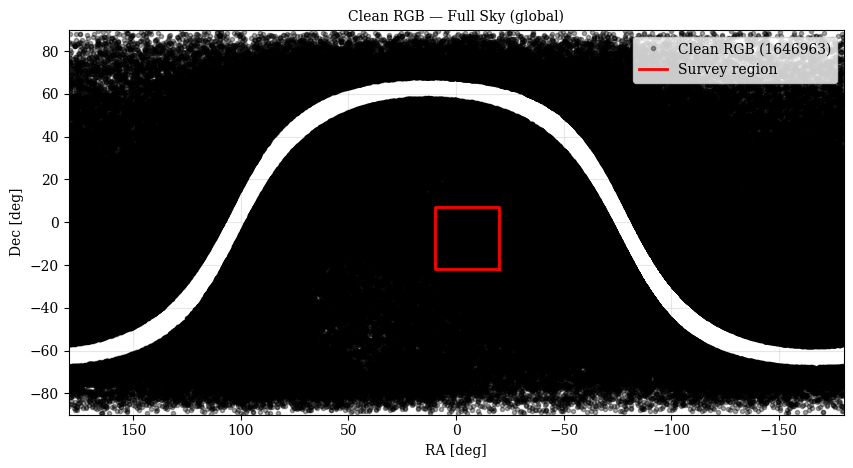

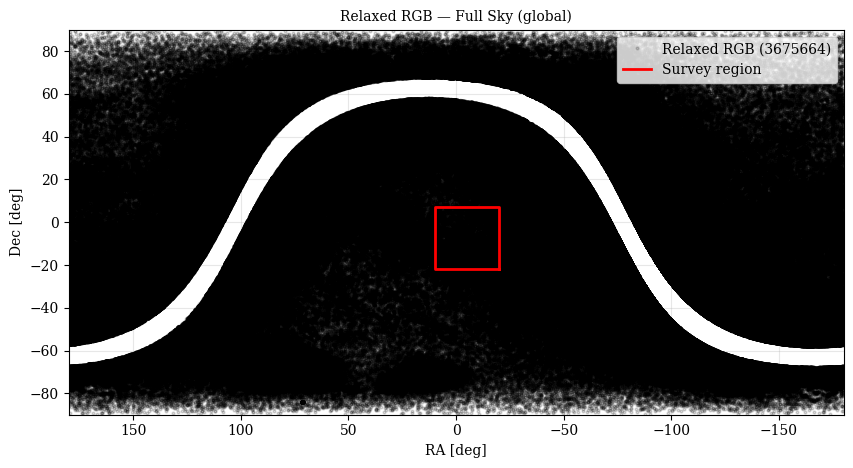

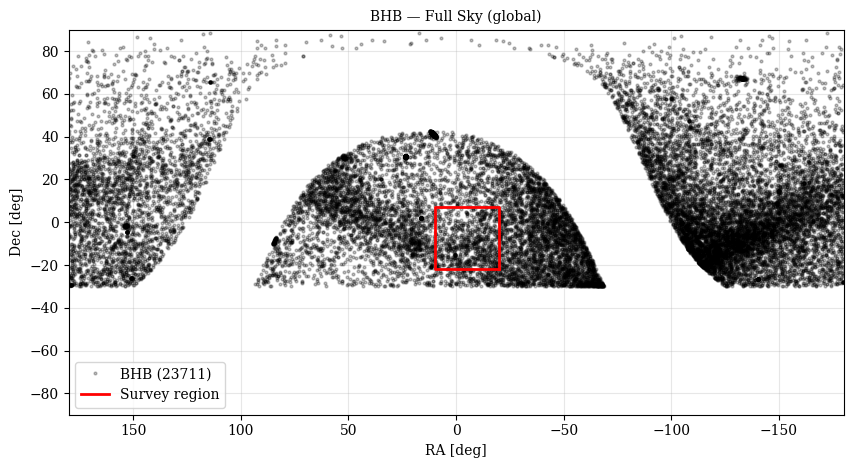

Text(0.5, 1.0, 'Gaia XP giants — Full Sky (global)')

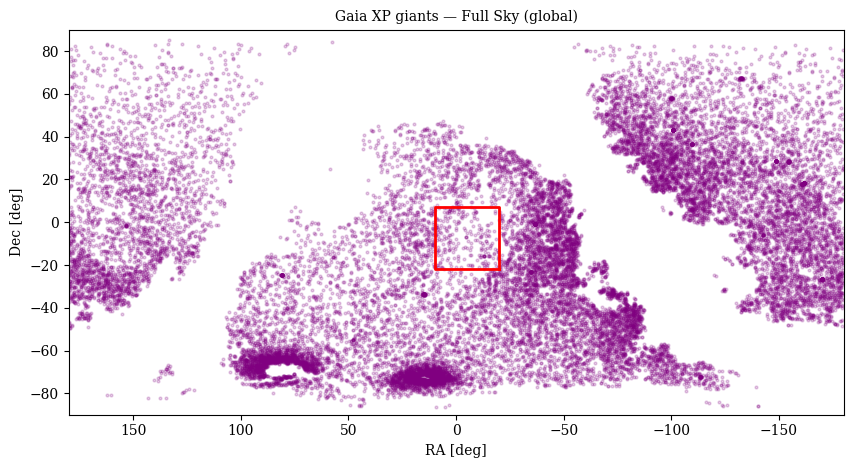

In [24]:
# Full-sky plots (global)

# Clean RGB (global)
plt.figure(figsize=[10,5])
plt.plot(ra180[mask_rgb_clean_global], dg['dec'][mask_rgb_clean_global],
         'o', ms=3, alpha=0.35, color='black', label=f'Clean RGB ({np.count_nonzero(mask_rgb_clean_global)})')
plt.plot([tarx[0], tarx[1], tarx[1], tarx[0], tarx[0]],
         [tary[0], tary[0], tary[1], tary[1], tary[0]], color='red', lw=2, label='Survey region')
plt.xlim(180, -180); plt.ylim(-90, 90)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Clean RGB — Full Sky (global)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# Relaxed RGB (global)
plt.figure(figsize=[10,5])
plt.plot(ra180[mask_rgb_relaxed_global], dg['dec'][mask_rgb_relaxed_global],
         'o', ms=2, alpha=0.15, color='black', label=f'Relaxed RGB ({np.count_nonzero(mask_rgb_relaxed_global)})')
plt.plot([tarx[0], tarx[1], tarx[1], tarx[0], tarx[0]],
         [tary[0], tary[0], tary[1], tary[1], tary[0]], color='red', lw=2, label='Survey region')
plt.xlim(180, -180); plt.ylim(-90, 90)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Relaxed RGB — Full Sky (global)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# BHB (global)
plt.figure(figsize=[10,5])
plt.plot(bhbra180[mask_bhb_global], bhb['dec'][mask_bhb_global],
         'o', ms=2, alpha=0.25, color='black', label=f'BHB ({np.count_nonzero(mask_bhb_global)})')
plt.plot([tarx[0], tarx[1], tarx[1], tarx[0], tarx[0]],
         [tary[0], tary[0], tary[1], tary[1], tary[0]], color='red', lw=2, label='Survey region')
plt.xlim(180, -180); plt.ylim(-90, 90)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('BHB — Full Sky (global)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# XP giants (global)
plt.figure(figsize=[10,5])
plt.plot(dara180[mask_xp_global], da['dec'][mask_xp_global],
         'o', ms=2, alpha=0.20, color='purple', label=f'XP giants ({np.count_nonzero(mask_xp_global)})')
plt.plot([tarx[0], tarx[1], tarx[1], tarx[0], tarx[0]],
         [tary[0], tary[0], tary[1], tary[1], tary[0]], color='red', lw=2, label='Survey region')
plt.xlim(180, -180); plt.ylim(-90, 90)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Gaia XP giants — Full Sky (global)')


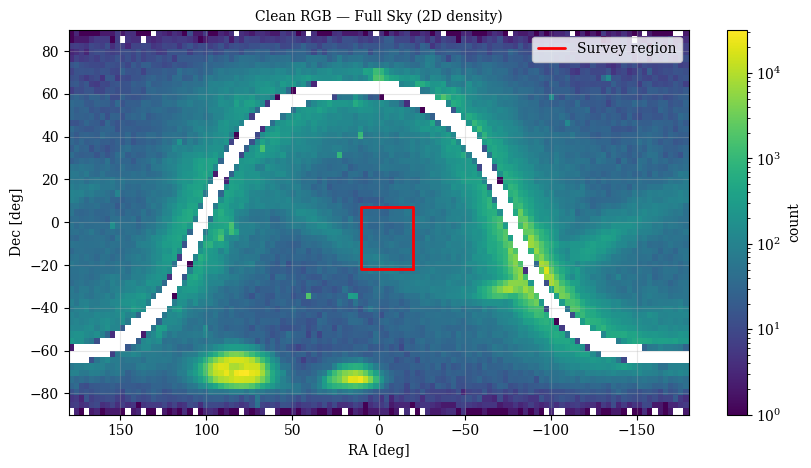

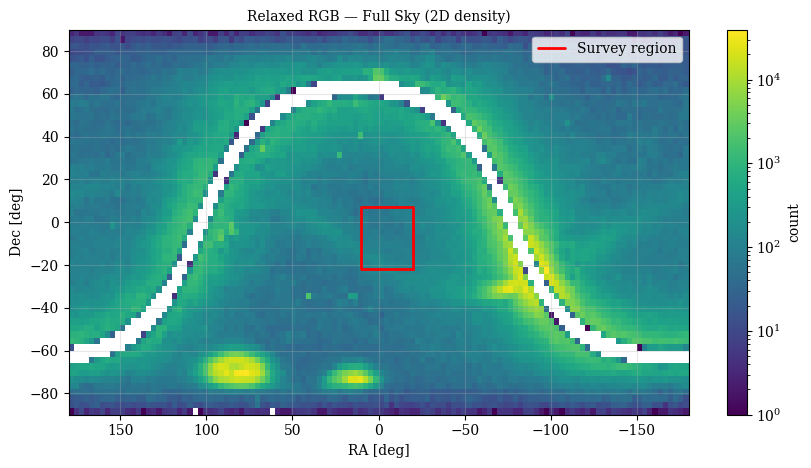

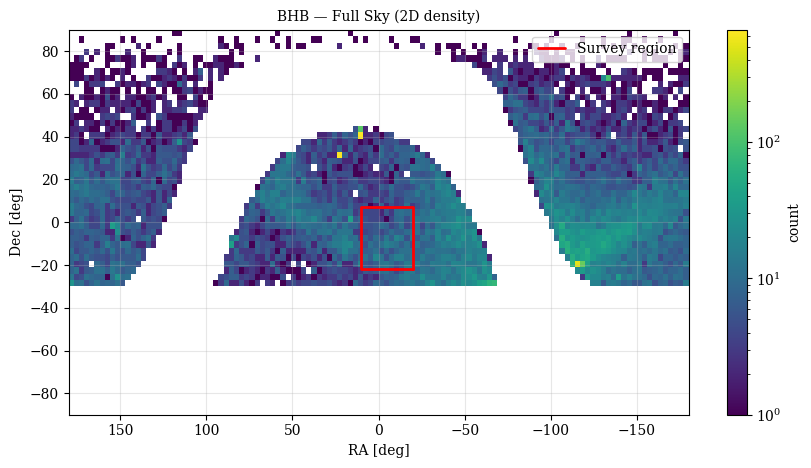

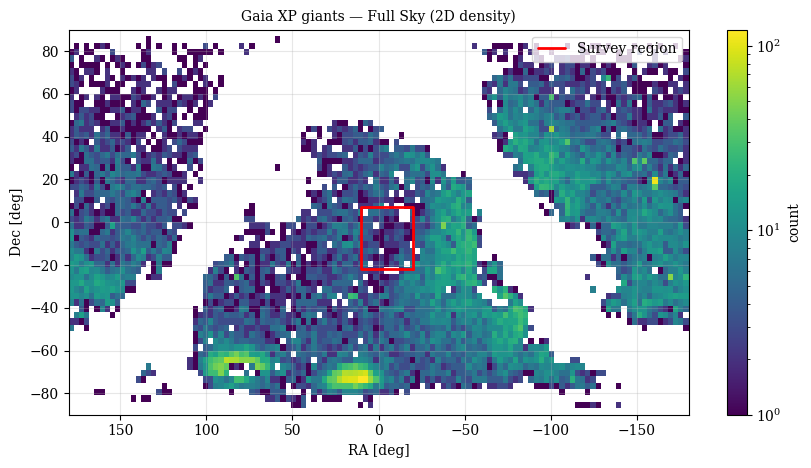

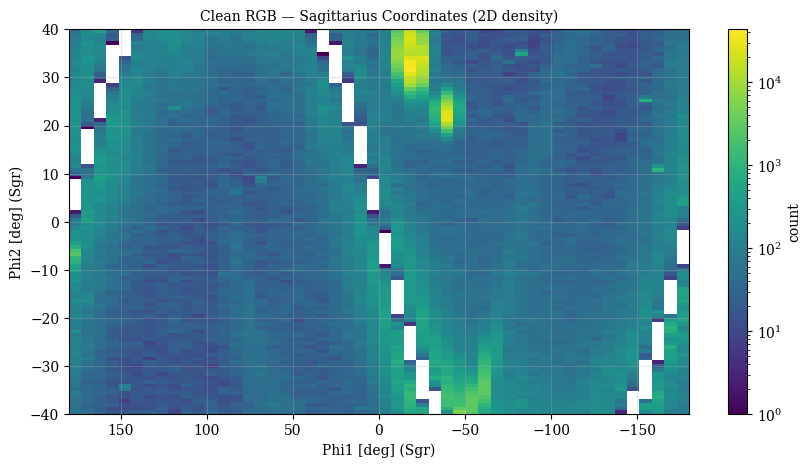

In [25]:
# Full-sky 2D histogram sky maps (densities) with survey box overlay — NO survey-region plots


# ---- sanity: required globals ----
req = [
    "tarx","tary",
    "ra180","bhbra180","dara180",
    "dg","bhb","da",
    "mask_rgb_clean_global","mask_rgb_relaxed_global","mask_bhb_global","mask_xp_global",
]
missing = [x for x in req if x not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from earlier cells: {missing}")


def hist2d_sky(x, y, bins, xrange, yrange, title, cb_label="count"):
    """2D histogram with log stretch; RA decreases to the right."""
    plt.hist2d(x, y, bins=bins, range=[xrange, yrange], norm=LogNorm(vmin=1), cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label(cb_label)
    # RA decreasing to the right (astronomy convention)
    plt.xlim(xrange[1], xrange[0])
    plt.ylim(yrange)
    draw_survey_box(tarx, tary, color="red", label="Survey region")
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend(loc="upper right")

# ---- binning choice for full sky (~2° x 2°) ----
full_bins = (180, 90)

# ==== GLOBAL maps ONLY ====
full_bins = tuple((np.array([180, 90]) // 1.5).astype(int))
plt.figure(figsize=(10,5))
hist2d_sky(ra180[mask_rgb_clean_global], dg["dec"][mask_rgb_clean_global],
           bins=full_bins, xrange=(-180, 180), yrange=(-90, 90),
           title="Clean RGB — Full Sky (2D density)")
plt.show()

plt.figure(figsize=(10,5))
hist2d_sky(ra180[mask_rgb_relaxed_global], dg["dec"][mask_rgb_relaxed_global],
           bins=full_bins, xrange=(-180, 180), yrange=(-90, 90),
           title="Relaxed RGB — Full Sky (2D density)")
plt.show()

plt.figure(figsize=(10,5))
hist2d_sky(bhbra180[mask_bhb_global], bhb["dec"][mask_bhb_global],
           bins=full_bins, xrange=(-180, 180), yrange=(-90, 90),
           title="BHB — Full Sky (2D density)")
plt.show()

plt.figure(figsize=(10,5))
hist2d_sky(dara180[mask_xp_global], da["dec"][mask_xp_global],
           bins=full_bins, xrange=(-180, 180), yrange=(-90, 90),
           title="Gaia XP giants — Full Sky (2D density)")
plt.show()

# ---- Optional: Sgr coordinates as density for Clean RGB (if sr available) ----
if "sr" in globals() and sr is not None:
    try:
        phi1, phi2 = sr.sphere_rotate(dg["ra"], dg["dec"], 72., -14., 191.10487)
        plt.figure(figsize=(10,5))
        plt.hist2d(phi1[mask_rgb_clean_global], phi2[mask_rgb_clean_global],
                   bins=(50, 100), range=[(-180, 180), (-40, 40)],
                   norm=LogNorm(vmin=1), cmap="viridis")
        plt.colorbar(label="count")
        plt.xlim(180, -180); plt.ylim(-40, 40)
        plt.xlabel("Phi1 [deg] (Sgr)"); plt.ylabel("Phi2 [deg] (Sgr)")
        plt.title("Clean RGB — Sagittarius Coordinates (2D density)")
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print("Skipping Sgr density plot (error computing Sgr coords):", e)

plt.show()

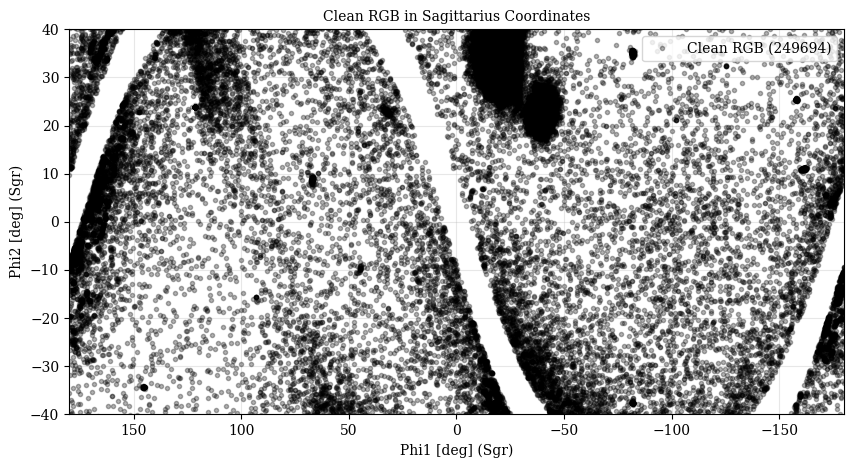

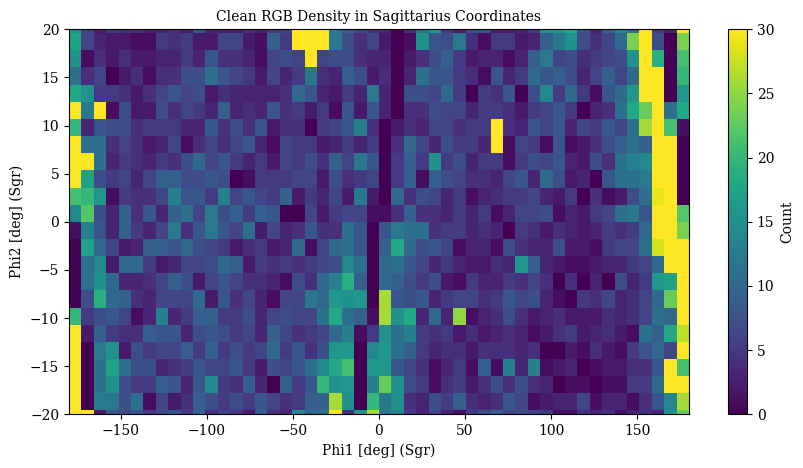

In [17]:
# Sagittarius coordinates (if helper is available)
if sr is None:
    print("sphere_rotate.py not found; skipping Sgr-coordinate plots.")
else:
    phi1, phi2 = sr.sphere_rotate(dg['ra'], dg['dec'], 72., -14., 191.10487)

    # scatter
    plt.figure(figsize=[10,5])
    plt.plot(phi1[mask_rgb_clean_global], phi2[mask_rgb_clean_global],
             'o', ms=3, alpha=0.3, color='black', label=f'Clean RGB ({np.count_nonzero(mask_rgb_clean_global)})')
    plt.xlim(180, -180); plt.ylim(-40, 40)
    plt.xlabel('Phi1 [deg] (Sgr)'); plt.ylabel('Phi2 [deg] (Sgr)')
    plt.title('Clean RGB in Sagittarius Coordinates')
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    # 2D density
    plt.figure(figsize=[10,5])
    plt.hist2d(phi1[mask_rgb_clean_global], phi2[mask_rgb_clean_global], bins=[50, 100], vmax=30)
    plt.colorbar(label='Count')
    plt.ylim(-20, 20)
    plt.xlabel('Phi1 [deg] (Sgr)'); plt.ylabel('Phi2 [deg] (Sgr)')
    plt.title('Clean RGB Density in Sagittarius Coordinates')
    plt.show()

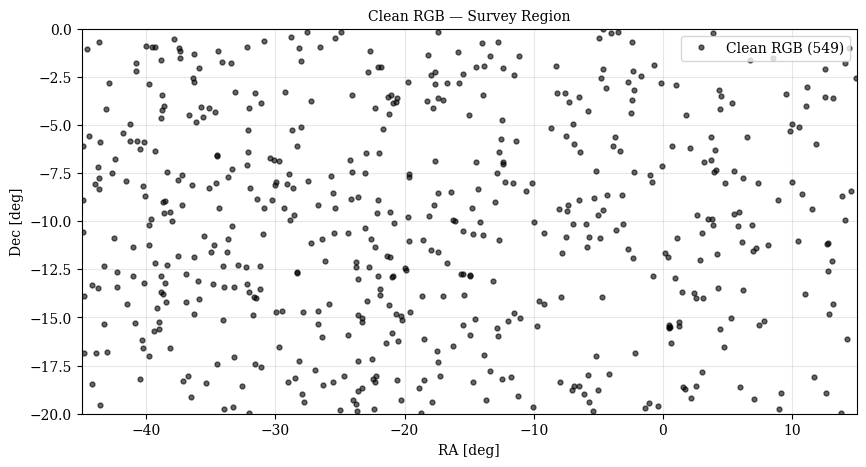

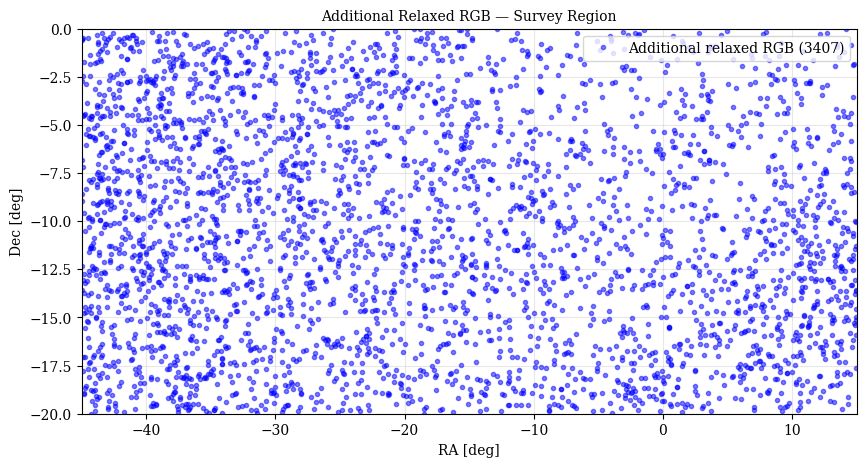

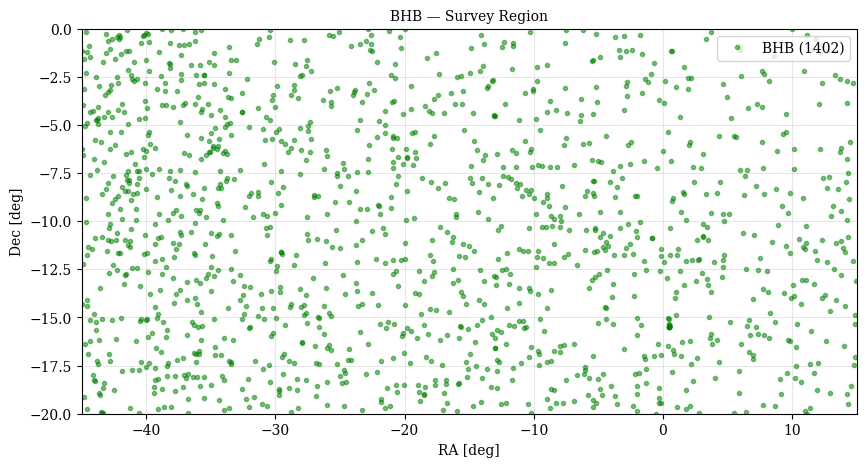

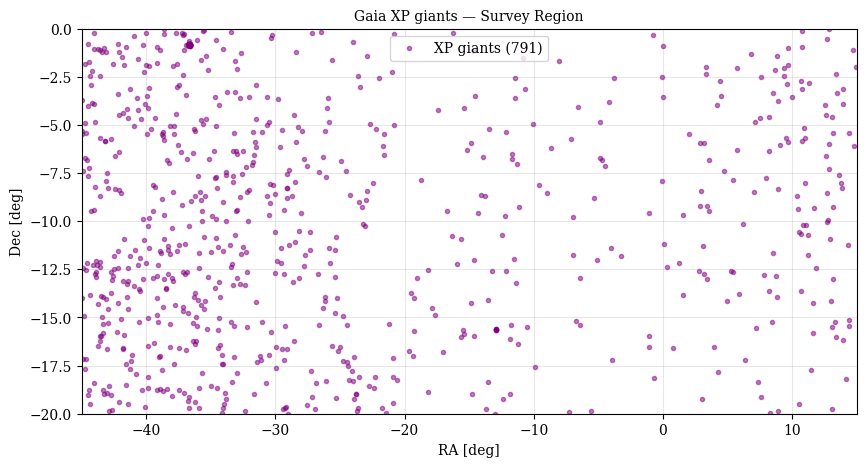

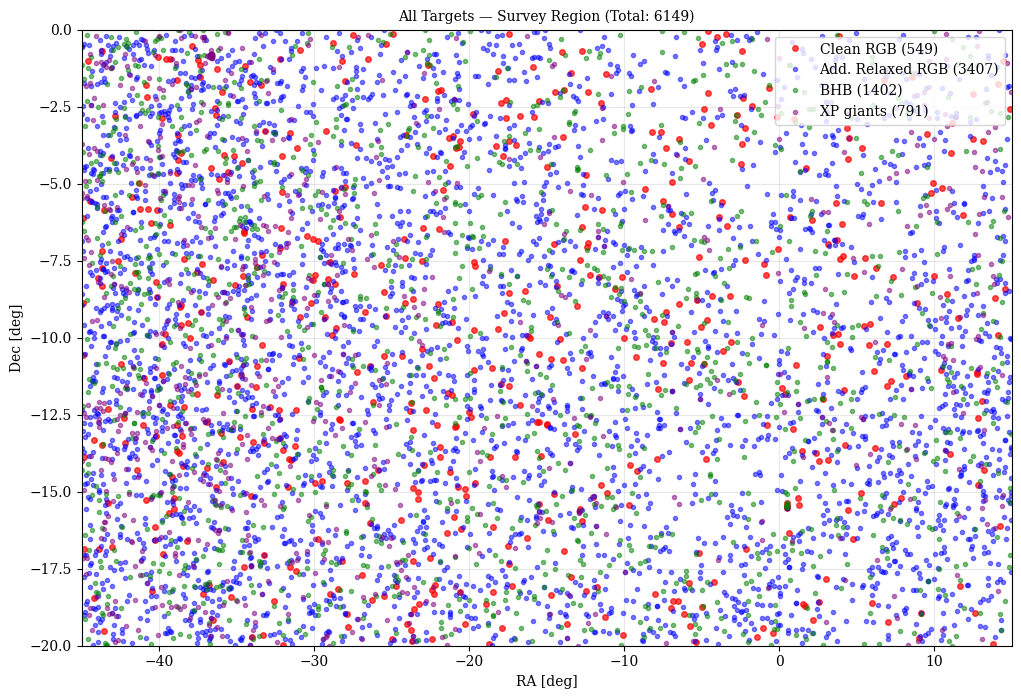

In [18]:
# Survey-region zoom plots

# Clean RGB
plt.figure(figsize=[10,5])
plt.plot(ra180[mask_rgb_clean_field], dg['dec'][mask_rgb_clean_field],
         'o', ms=3.5, alpha=0.6, color='black', label=f'Clean RGB ({wtar1_xy.size})')
plt.xlim(tarx); plt.ylim(tary)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Clean RGB — Survey Region')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# Additional relaxed RGB
plt.figure(figsize=[10,5])
plt.plot(ra180[mask_relaxed_add_field], dg['dec'][mask_relaxed_add_field],
         'o', ms=3, alpha=0.5, color='blue', label=f'Additional relaxed RGB ({keep_wtar12_xy.size})')
plt.xlim(tarx); plt.ylim(tary)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Additional Relaxed RGB — Survey Region')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# BHB
plt.figure(figsize=[10,5])
plt.plot(bhbra180[mask_bhb_field], bhb['dec'][mask_bhb_field],
         'o', ms=3, alpha=0.5, color='green', label=f'BHB ({wtar2_xy.size})')
plt.xlim(tarx); plt.ylim(tary)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('BHB — Survey Region')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# XP giants
plt.figure(figsize=[10,5])
plt.plot(dara180[mask_xp_field], da['dec'][mask_xp_field],
         'o', ms=3, alpha=0.5, color='purple', label=f'XP giants ({wtar3_xy.size})')
plt.xlim(tarx); plt.ylim(tary)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]'); plt.title('Gaia XP giants — Survey Region')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# Combined
plt.figure(figsize=[12,8])
plt.plot(ra180[mask_rgb_clean_field], dg['dec'][mask_rgb_clean_field],
         'o', ms=4, alpha=0.7, color='red', label=f'Clean RGB ({wtar1_xy.size})')
plt.plot(ra180[mask_relaxed_add_field], dg['dec'][mask_relaxed_add_field],
         'o', ms=3, alpha=0.5, color='blue', label=f'Add. Relaxed RGB ({keep_wtar12_xy.size})')
plt.plot(bhbra180[mask_bhb_field], bhb['dec'][mask_bhb_field],
         'o', ms=3, alpha=0.5, color='green', label=f'BHB ({wtar2_xy.size})')
plt.plot(dara180[mask_xp_field], da['dec'][mask_xp_field],
         'o', ms=3, alpha=0.5, color='purple', label=f'XP giants ({wtar3_xy.size})')
plt.xlim(tarx); plt.ylim(tary)
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]')
plt.title(f'All Targets — Survey Region (Total: {wtar1_xy.size + keep_wtar12_xy.size + wtar2_xy.size + wtar3_xy.size})')
plt.legend(); plt.grid(alpha=0.3); plt.show()

In [20]:
# Assemble target arrays (vectorized) & save FITS

def pack_rgb(idx, priority):
    return np.rec.fromarrays([
        dg['source_id'][idx], dg['ra'][idx], dg['dec'][idx],
        np.full(idx.size, 3, dtype=np.int64),                 # GAIA_REV_ID placeholder
        np.zeros(idx.size, dtype=np.int64),                   # PS1_ID placeholder
        np.full(idx.size, priority, dtype=np.int64)
    ], names=['SOURCE_ID','RA','DEC','GAIA_REV_ID','PS1_ID','PRIORITY'])

def pack_bhb(idx, priority):
    return np.rec.fromarrays([
        bhb['source_id'][idx], bhb['ra'][idx], bhb['dec'][idx],
        np.full(idx.size, 3, dtype=np.int64),
        np.zeros(idx.size, dtype=np.int64),
        np.full(idx.size, priority, dtype=np.int64)
    ], names=['SOURCE_ID','RA','DEC','GAIA_REV_ID','PS1_ID','PRIORITY'])

def pack_xp(idx, priority):
    return np.rec.fromarrays([
        da['source_id'][idx], da['ra'][idx], da['dec'][idx],
        np.full(idx.size, 3, dtype=np.int64),
        np.zeros(idx.size, dtype=np.int64),
        np.full(idx.size, priority, dtype=np.int64)
    ], names=['SOURCE_ID','RA','DEC','GAIA_REV_ID','PS1_ID','PRIORITY'])

# build field targets (you can reorder priorities/categories as you prefer)
dtar_clean   = pack_rgb(wtar1_xy, rgb_params['clean']['priority'])
dtar_relaxed = pack_rgb(keep_wtar12_xy, rgb_params['relaxed']['priority'])
dtar_bhb     = pack_bhb(wtar2_xy, bhb_params['priority'])
dtar_xp      = pack_xp(wtar3_xy, xp_params['priority'])

targets_all  = np.concatenate([dtar_clean, dtar_relaxed, dtar_bhb, dtar_xp])

# Save FITS (optional; comment out to skip writing)
date_suffix = '021023'  # keep your tag or change
fname = f'Pisces_{date_suffix}.fits'
fname = f'../{fname}'
Table(targets_all, copy=False).write(fname, overwrite=True)
with fits.open(fname, mode='update') as hdul:
    hdr = hdul[0].header
    hdr['VERSION']  = date_suffix
    hdr['SURVEY']   = 'WEAVE Pisces'
    hdr['TARGET_N'] = targets_all.size

print(f"Saved: {fname} (N={targets_all.size})")

Saved: ../Pisces_021023.fits (N=6149)
